## Imports Here

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import os
from datetime import datetime
import pandas as pd
from torchvision.io import read_image
import matplotlib.pyplot as plt

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file='./pure_annotations.csv', img_dir='./Pure', transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        
        # image = read_image(img_path)

        label = self.img_labels.iloc[idx, 1]
        if self.transform:

            image = self.transform(image)
            
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])
(256, 256, 3)
img shape: (256, 256, 3), label shape: torch.Size([])


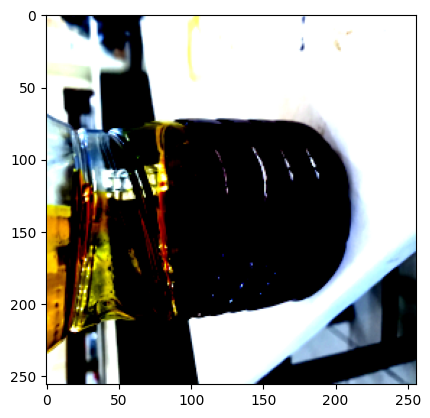

Label: 0


In [3]:

batch_size = 32

dataset = CustomImageDataset(transform=transform)
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[0].squeeze()

img = train_features[3].permute(1, 2, 0).numpy()
print(f"{img.shape}")
img = img.squeeze()
label = train_labels[0]

print(f"img shape: {img.shape}, label shape: {label.shape}")
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
class PureDetectionCNN(nn.Module):
    def __init__(self):
        super(PureDetectionCNN, self).__init__()
        
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 40 * 40, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, 1)  # Output layer with 1 neuron for binary classification
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = PureDetectionCNN().to(device)

# Print the model architecture
print(model)

PureDetectionCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=262144, out_features=1, bias=True)
)


In [6]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.float().unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print the running loss after every batch
        print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss/(i+1):.4f}")

Epoch 1, Batch 1, Loss: 0.6760
Epoch 1, Batch 2, Loss: 0.3380
Epoch 1, Batch 3, Loss: 0.2253
Epoch 2, Batch 1, Loss: 0.0000
Epoch 2, Batch 2, Loss: 0.0000
Epoch 2, Batch 3, Loss: 0.0000
Epoch 3, Batch 1, Loss: 0.0000
Epoch 3, Batch 2, Loss: 0.0000
Epoch 3, Batch 3, Loss: 0.0000
Epoch 4, Batch 1, Loss: 0.0000
Epoch 4, Batch 2, Loss: 0.0000
Epoch 4, Batch 3, Loss: 0.0000
Epoch 5, Batch 1, Loss: 0.0000
Epoch 5, Batch 2, Loss: 0.0000
Epoch 5, Batch 3, Loss: 0.0000
Epoch 6, Batch 1, Loss: 0.0000
Epoch 6, Batch 2, Loss: 0.0000
Epoch 6, Batch 3, Loss: 0.0000
Epoch 7, Batch 1, Loss: 0.0000
Epoch 7, Batch 2, Loss: 0.0000
Epoch 7, Batch 3, Loss: 0.0000
Epoch 8, Batch 1, Loss: 0.0000
Epoch 8, Batch 2, Loss: 0.0000
Epoch 8, Batch 3, Loss: 0.0000
Epoch 9, Batch 1, Loss: 0.0000
Epoch 9, Batch 2, Loss: 0.0000
Epoch 9, Batch 3, Loss: 0.0000
Epoch 10, Batch 1, Loss: 0.0000
Epoch 10, Batch 2, Loss: 0.0000
Epoch 10, Batch 3, Loss: 0.0000
